1. Segmentação de Clientes (Perfil Comportamental e Financeiro)
Objetivo: Agrupar os clientes com base em comportamentos financeiros, operacionais e histórico bancário.

Variáveis principais:

Renda e operações financeiras: renda_cart, Qtd_Op_em_cart, VlrLiberado_12meses_Consig
Histórico de pedidos e cancelamentos: Pedidos, Qtd_Pedidos_cancelados, Saldo_Gerado_cancelado
Relacionamento com o banco: Historico_QtdOutrosBancos, Tempocliente
Perguntas a responder:

Existem clientes que operam pouco, mas têm alta renda (potencial de cross-sell)?
Quem são os clientes com alta taxa de cancelamento?
Que grupos têm maior fidelidade ao banco com base no tempo e histórico?
Método recomendado:

K-means: Agrupar clientes com base em perfis financeiros e operacionais.
DBSCAN: Identificar grupos de clientes com comportamentos densos específicos, como alta operação e baixo cancelamento.
2. Identificação de Clientes em Risco de Churn
Objetivo: Detectar clusters de clientes com comportamentos associados ao risco de churn (desistência do serviço).

Variáveis principais:

Interação recente: Pedidos_Mes, Saldo_Mes
Relacionamento de longo prazo: Tempocliente, Historico_QtdOutrosBancos
Problemas operacionais: Qtd_Pedidos_cancelados, Meses_Distintos_Pedido_cancelados
Perguntas a responder:

Existem grupos de clientes que têm poucas operações recentes, mas alta taxa de cancelamento?
Quem são os clientes que estão reduzindo a frequência de operações?
Método recomendado:

Hierarchical Clustering: Para explorar estruturas hierárquicas nos dados e identificar padrões complexos.
PCA + K-means: Reduzir a dimensionalidade e focar em variáveis que explicam o comportamento.

In [1]:
import pandas as pd
import random
import numpy as np

In [2]:
#criacao dos dados
random.seed(42)  # 
np.random.seed(42)  

# Função para gerar CPF
def gerar_tipo_cpf():
    cpf = [random.randint(0, 9) for _ in range(9)]
    for _ in range(2):
        soma = sum(x * y for x, y in zip(cpf, range(len(cpf) + 1, 1, -1)))
        resto = soma % 11
        cpf.append(11 - resto if resto > 1 else 0)
    return "".join(map(str, cpf))

# Gerar 10k linhas de dados simulados
n_linhas = 10000
data = {
    "Cliente_CPF": [gerar_tipo_cpf() for _ in range(n_linhas)],
    "Qtd_Op_em_cart": np.random.randint(1, 100, n_linhas),
    "renda_cart": np.random.uniform(1000, 50000, n_linhas),
    "Qtd_12meses_Consig": np.random.randint(0, 50, n_linhas),
    "VlrLiberado_12meses_Consig": np.random.uniform(1000, 100000, n_linhas),
    "Meses_Distintos_Consig": np.random.randint(0, 12, n_linhas),
    "Pedidos": np.random.randint(0, 50, n_linhas),
    "Pedidos_Mes": np.random.randint(0, 5, n_linhas),
    "Meses_Distintos_Pedido": np.random.randint(0, 12, n_linhas),
    "Qtd_Pedidos_cancelados": np.random.randint(0, 50, n_linhas),
    "Meses_Distintos_Pedido_cancelados": np.random.randint(0, 12, n_linhas),
    "Saldo_Gerado_cancelado": np.random.uniform(0, 100000, n_linhas),
    "Saldo_Mes": np.random.uniform(0, 10000, n_linhas),
    "Historico_QtdOutrosBancos": np.random.randint(0, 20, n_linhas),
    "Saldo_Gerado_cancelado_Mes": np.random.uniform(0, 10000, n_linhas),
    "SOW": np.random.uniform(0, 1, n_linhas),
    "Tempocliente": np.random.randint(0, 30, n_linhas),
}

df_pd_cluster = pd.DataFrame(data)

In [3]:
df_pd_cluster.columns

Index(['Cliente_CPF', 'Qtd_Op_em_cart', 'renda_cart', 'Qtd_12meses_Consig',
       'VlrLiberado_12meses_Consig', 'Meses_Distintos_Consig', 'Pedidos',
       'Pedidos_Mes', 'Meses_Distintos_Pedido', 'Qtd_Pedidos_cancelados',
       'Meses_Distintos_Pedido_cancelados', 'Saldo_Gerado_cancelado',
       'Saldo_Mes', 'Historico_QtdOutrosBancos', 'Saldo_Gerado_cancelado_Mes',
       'SOW', 'Tempocliente'],
      dtype='object')

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from factor_analyzer import FactorAnalyzer, calculate_kmo
import matplotlib.pyplot as plt

df = df_pd_cluster.copy()

# Pré-processamento dos Dados

quantitative_columns = [
    'Cliente_CPF', 'Qtd_Op_em_cart', 'renda_cart', 'Qtd_12meses_Consig',
       'VlrLiberado_12meses_Consig', 'Meses_Distintos_Consig', 'Pedidos',
       'Pedidos_Mes', 'Meses_Distintos_Pedido', 'Qtd_Pedidos_cancelados',
       'Meses_Distintos_Pedido_cancelados', 'Saldo_Gerado_cancelado',
       'Saldo_Mes', 'Historico_QtdOutrosBancos', 'Saldo_Gerado_cancelado_Mes',
       'SOW', 'Tempocliente']

data = df[quantitative_columns]

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

data_scaled = pd.DataFrame(data_scaled, columns=quantitative_columns)

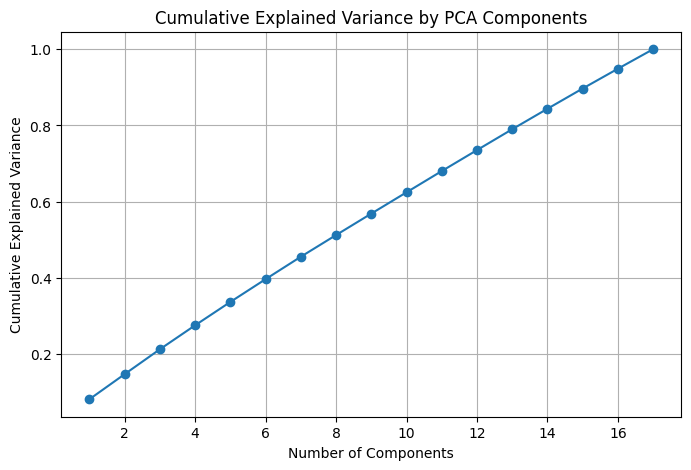

In [5]:
### Análise de Componentes Principais (PCA)
pca = PCA()
data_pca = pca.fit_transform(data_scaled)

explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

pca = PCA(n_components=2)
data_pca_2d = pca.fit_transform(data_scaled)

In [6]:
### Análise Fatorial

kmo_all, kmo_model = calculate_kmo(data_scaled)
print(f"KMO Test Value: {kmo_model:.3f}")  # KMO > 0.6 é recomendado

# Teste de esfericidade de Bartlett
from scipy.stats import bartlett
bartlett_test = bartlett(*data_scaled.T)
print(f"Bartlett Test: Chi-square = {bartlett_test.statistic:.3f}, p-value = {bartlett_test.pvalue:.3f}")

fa = FactorAnalyzer(n_factors=3, rotation="varimax")
fa.fit(data_scaled)

factor_loadings = pd.DataFrame(fa.loadings_, index=quantitative_columns, columns=[f"Factor{i+1}" for i in range(3)])
print(factor_loadings)

c:\Python312\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


KMO Test Value: 0.498


c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Bartlett Test: Chi-square = nan, p-value = nan
                                    Factor1   Factor2   Factor3
Cliente_CPF                       -0.000244 -0.025872  0.064806
Qtd_Op_em_cart                     0.006731 -0.001771  0.058311
renda_cart                         0.018080 -0.000023  0.003030
Qtd_12meses_Consig                 0.000625  0.021154 -0.013667
VlrLiberado_12meses_Consig         0.023975  0.978165  0.194010
Meses_Distintos_Consig            -0.006795 -0.001387  0.054133
Pedidos                           -0.017319  0.005957  0.059283
Pedidos_Mes                        0.012284 -0.010174  0.086738
Meses_Distintos_Pedido            -0.025664 -0.017688  0.021206
Qtd_Pedidos_cancelados            -0.014757  0.007788 -0.025191
Meses_Distintos_Pedido_cancelados -0.002238 -0.018277  0.058012
Saldo_Gerado_cancelado             0.014837  0.035241 -0.206800
Saldo_Mes                          0.997116 -0.026934  0.007116
Historico_QtdOutrosBancos          0.002720  0.035427 -0.

c:\Python312\Lib\site-packages\scipy\stats\_morestats.py:3061: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 + 1.0/(3*(k - 1)) * ((np.sum(1.0/(Ni - 1.0), axis=0)) -
c:\Python312\Lib\site-packages\scipy\stats\_morestats.py:3062: RuntimeWarning: divide by zero encountered in scalar divide
  1.0/(Ntot - k))
c:\Python312\Lib\site-packages\scipy\stats\_morestats.py:3061: RuntimeWarning: invalid value encountered in scalar subtract
  denom = 1.0 + 1.0/(3*(k - 1)) * ((np.sum(1.0/(Ni - 1.0), axis=0)) -


In [7]:
correlation_matrix = pd.DataFrame(data_scaled, columns=quantitative_columns).corr()
print(correlation_matrix)

                                   Cliente_CPF  Qtd_Op_em_cart  renda_cart  \
Cliente_CPF                           1.000000        0.015493   -0.002470   
Qtd_Op_em_cart                        0.015493        1.000000   -0.012090   
renda_cart                           -0.002470       -0.012090    1.000000   
Qtd_12meses_Consig                    0.009443       -0.001560   -0.011661   
VlrLiberado_12meses_Consig           -0.013324        0.010164    0.001468   
Meses_Distintos_Consig                0.011557        0.008211   -0.000501   
Pedidos                              -0.009805        0.004735   -0.012698   
Pedidos_Mes                           0.006385        0.008589    0.008863   
Meses_Distintos_Pedido               -0.000903        0.002379    0.000917   
Qtd_Pedidos_cancelados               -0.006048       -0.000176    0.016740   
Meses_Distintos_Pedido_cancelados     0.009051        0.010918   -0.007558   
Saldo_Gerado_cancelado               -0.014162       -0.001441  

O Que o KMO Significa
O KMO mede a proporção de variância entre variáveis que pode ser explicada pelos fatores. Valores mais altos (
>
0.6
>0.6) indicam que as variáveis estão correlacionadas o suficiente para formar fatores significativos.
Rwsultado do teste: 0.498
Como Melhorar o KMO
Remova Variáveis de Baixa Correlação:

Revise a matriz de correlação e identifique variáveis que têm correlação baixa com as outras.
Variáveis com correlação próxima de zero com todas as outras podem ser removidas.

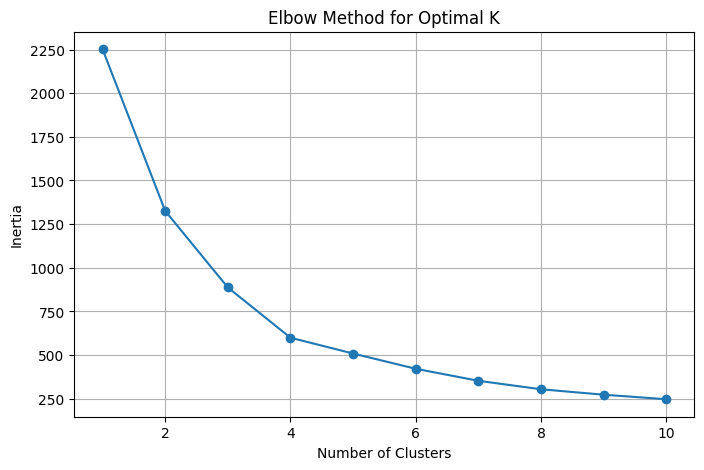

In [8]:
###Clusterização com K-means
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca_2d)
    inertia.append(kmeans.inertia_)

# método Elbow
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(data_pca_2d)

data_scaled['Cluster'] = clusters

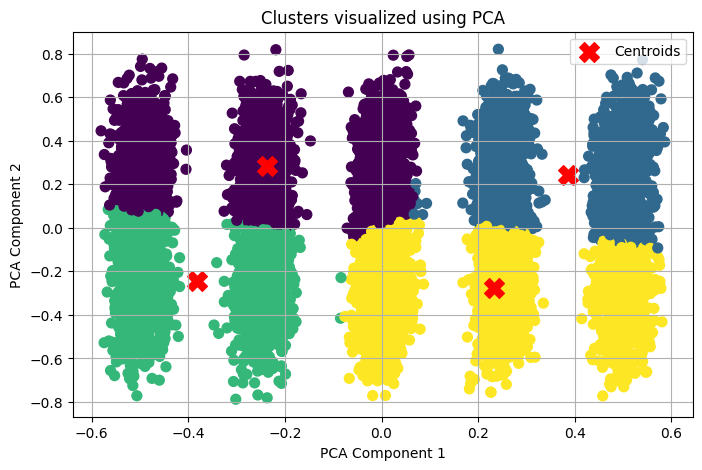

In [9]:
plt.figure(figsize=(8, 5))
plt.scatter(data_pca_2d[:, 0], data_pca_2d[:, 1], c=clusters, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title('Clusters visualized using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

In [10]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

silhouette_avg = silhouette_score(data_pca_2d, clusters)
davies_bouldin = davies_bouldin_score(data_pca_2d, clusters)
calinski_harabasz = calinski_harabasz_score(data_pca_2d, clusters)

print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")


Silhouette Score: 0.394
Davies-Bouldin Index: 0.824
Calinski-Harabasz Index: 9185.553


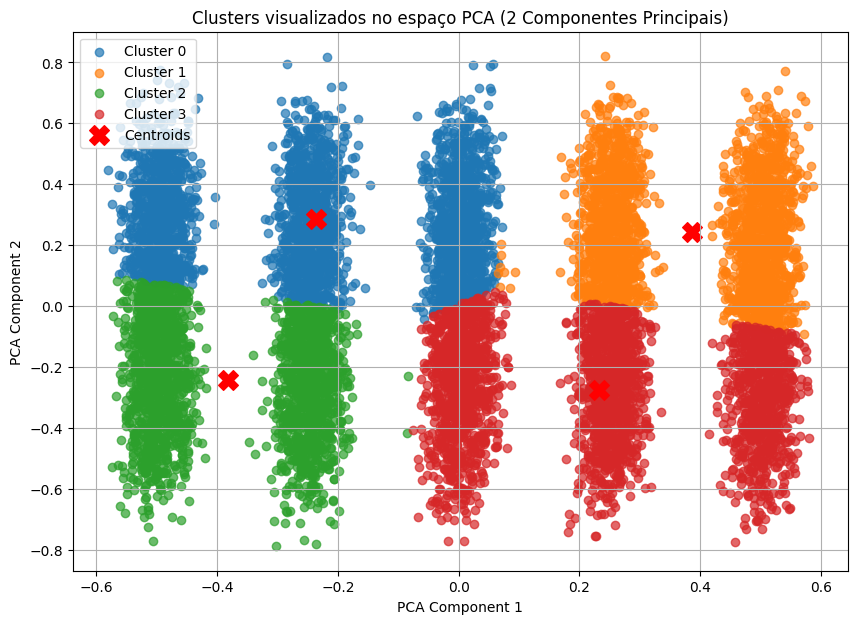

In [11]:
import matplotlib.pyplot as plt

# Plotar os clusters no espaço PCA (2)
plt.figure(figsize=(10, 7))
for cluster in np.unique(clusters):
    plt.scatter(
        data_pca_2d[clusters == cluster, 0],  # Coordenada da 1ª componente principal
        data_pca_2d[clusters == cluster, 1],  # Coordenada da 2ª componente principal
        label=f'Cluster {cluster}',          # Nome do cluster
        alpha=0.7                             # Transparência
    )

# Adicionar os centróides dos clusters
plt.scatter(
    kmeans.cluster_centers_[:, 0],  # Coordenada X do centróide
    kmeans.cluster_centers_[:, 1],  # Coordenada Y do centróide
    s=200,                          # Tamanho do marcador
    c='red',                        # Cor dos centróides
    label='Centroids',              # Legenda
    marker='X'                      # Símbolo
)


plt.title('Clusters visualizados no espaço PCA (2 Componentes Principais)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()
